Loaded: Gene Expression Analysis and Disease Relationship.csv shape: (1000, 8)


,PatientID,Age,Gender,Gene_X_Expression,Gene_Y_Expression,SmokingStatus,DiseaseStatus,TreatmentResponse
0,1,45,0,5.78,3.21,1,1,1
1,2,62,1,7.12,5.89,2,2,0
2,3,38,0,3.15,1.98,0,0,2
3,4,55,1,6.54,4.76,1,1,1
4,5,71,0,8.01,6.55,2,2,0



Running pipeline for target: DiseaseStatus
Dropped leakage/ID columns: ['PatientID', 'SmokingStatus', 'TreatmentResponse']
Numeric cols: ['Age', 'Gene_X_Expression', 'Gene_Y_Expression']
Categorical cols: ['Gender']
Target distribution:


,count
DiseaseStatus,
0,962
2,20
1,18


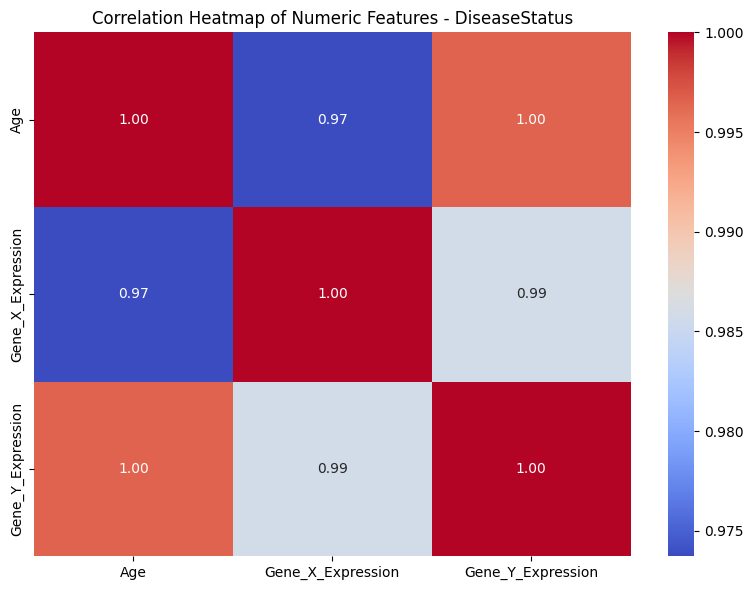


Top features by ANOVA F-score (before PCA):


,0
Gene_X_Expression,63.252139
Gene_Y_Expression,26.249856
Age,15.211441
Gender,2.557372


PCA reduced 4 features -> 2 components (explained variance=99.10%)


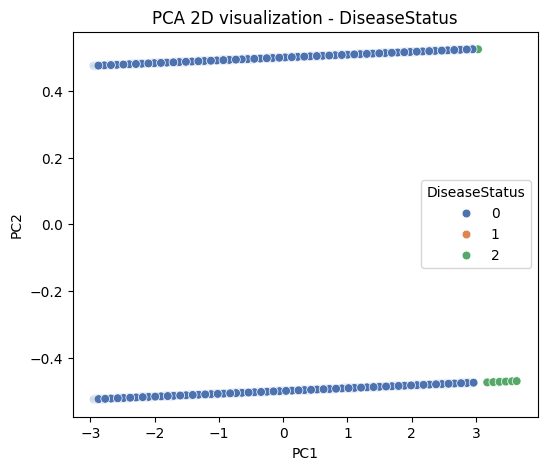

Train/test shapes: (800, 2) (200, 2)
Train class counts: {0: 770, 2: 16, 1: 14}
After SMOTE train counts: {0: 770, 1: 770, 2: 770}

Tuning LogisticRegression ...
Best params: {'C': 0.1, 'penalty': 'l1'}


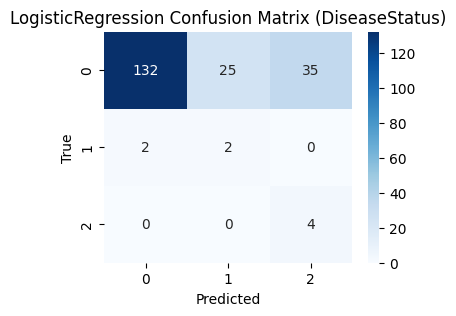

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81       192
           1       0.07      0.50      0.13         4
           2       0.10      1.00      0.19         4

    accuracy                           0.69       200
   macro avg       0.39      0.73      0.37       200
weighted avg       0.95      0.69      0.78       200



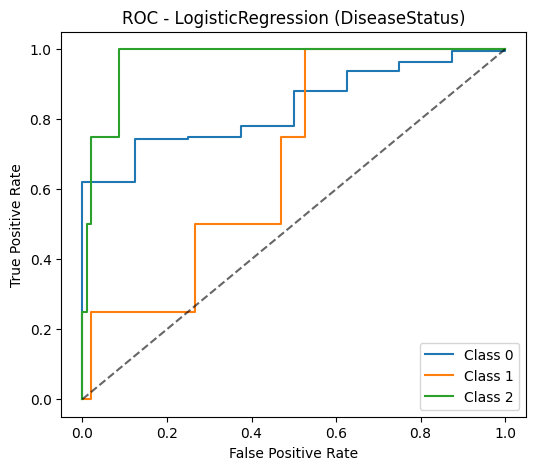


Tuning RandomForest ...
Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


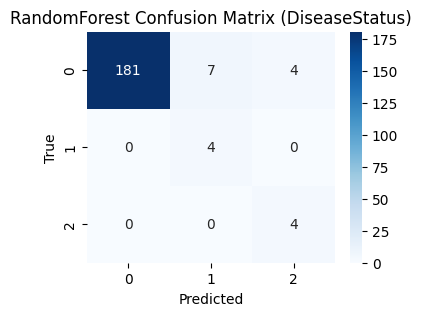

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       192
           1       0.36      1.00      0.53         4
           2       0.50      1.00      0.67         4

    accuracy                           0.94       200
   macro avg       0.62      0.98      0.72       200
weighted avg       0.98      0.94      0.96       200



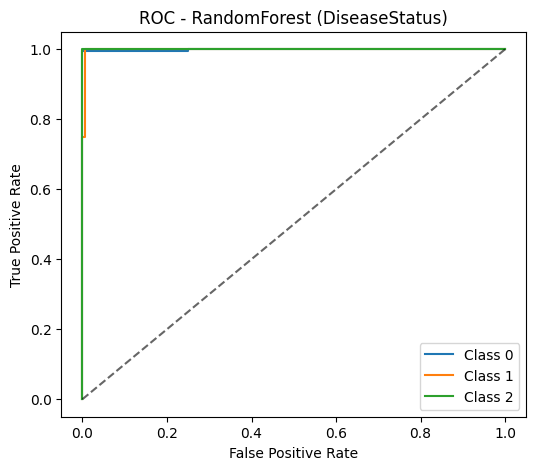


Tuning SVM ...
Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


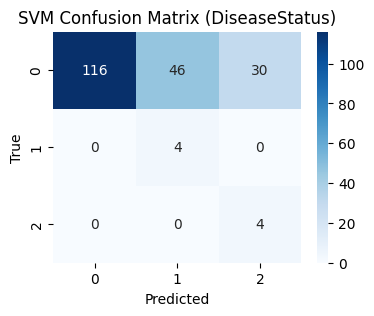

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75       192
           1       0.08      1.00      0.15         4
           2       0.12      1.00      0.21         4

    accuracy                           0.62       200
   macro avg       0.40      0.87      0.37       200
weighted avg       0.96      0.62      0.73       200



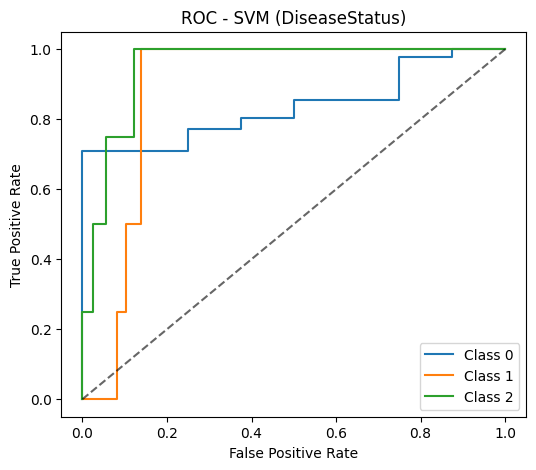


Summary results:


,Model,Accuracy,Precision,Recall,F1,AUC
0,LogisticRegression,0.690,0.949204,0.690,0.783725,0.833635
1,RandomForest,0.945,0.977273,0.945,0.955689,0.998724
2,SVM,0.620,0.963953,0.620,0.730290,0.837934



Top original features inferred from RF (via PCA loadings):


,0
Age,0.385512
Gene_Y_Expression,0.385168
Gene_X_Expression,0.383052
Gender,0.342278


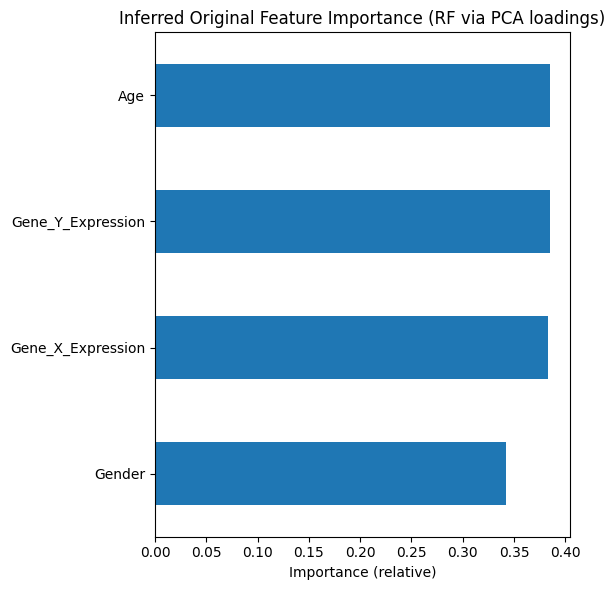


Selected diseased label for filtering: 1
Diseased subset shape: (18, 8)
TreatmentResponse counts in diseased subset:


,count
TreatmentResponse,
1,18


Only one class present for TreatmentResponse in diseased subset; cannot train classifier. Skipping.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

try:
    from imblearn.over_sampling import SMOTE
    smote_available = True
except Exception:
    smote_available = False

INPUT_CSV = "Gene Expression Analysis and Disease Relationship.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2
K_ANOVA = 10
PCA_VARIANCE = 0.95

if not os.path.exists(INPUT_CSV):
    raise FileNotFoundError(f"Place the CSV in the working dir or update INPUT_CSV path. Expected: {INPUT_CSV}")
df = pd.read_csv(INPUT_CSV)
print("Loaded:", INPUT_CSV, "shape:", df.shape)
display(df.head())

def remove_leakage_columns(X, y, leak_candidates=None, corr_threshold=0.95, verbose=True):
    dropped = []
    X = X.copy()
    if leak_candidates is None:
        leak_candidates = ["PatientID","patientid","SmokingStatus","smokingstatus",
                           "TreatmentResponse","treatmentresponse","Label","label"]
    # drop exact-match leak candidates
    for c in list(X.columns):
        if any(c.lower() == cand.lower() for cand in leak_candidates):
            X.drop(columns=[c], inplace=True)
            dropped.append(c)
    # drop numeric features highly correlated with target
    numeric = X.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric:
        try:
            r = np.corrcoef(X[col].astype(float), y.astype(float))[0,1]
        except Exception:
            r = 0
        if not np.isnan(r) and abs(r) >= corr_threshold:
            X.drop(columns=[col], inplace=True)
            dropped.append(col)
    if verbose:
        if dropped:
            print("Dropped leakage/ID columns:", dropped)
        else:
            print(f"No leakage columns dropped (corr_threshold={corr_threshold}).")
    return X, dropped

def run_pipeline_with_pca(df_in, TARGET, pca_variance=PCA_VARIANCE, corr_threshold=0.95):
    print("\n" + "="*60)
    print(f"Running pipeline for target: {TARGET}")
    print("="*60)
    if TARGET not in df_in.columns:
        print("Target not in dataframe. Skipping.")
        return None

    # split features/target
    X = df_in.drop(columns=[TARGET]).copy()
    y = df_in[TARGET].copy()

    # remove likely leakage columns (for this target)
    X, dropped = remove_leakage_columns(X, y, corr_threshold=corr_threshold, verbose=True)

    # drop duplicates
    merged = pd.concat([X, y.reset_index(drop=True)], axis=1)
    dups = merged.duplicated().sum()
    if dups > 0:
        print(f"Dropping {dups} duplicated rows.")
        merged = merged.drop_duplicates().reset_index(drop=True)
        X = merged.drop(columns=[TARGET])
        y = merged[TARGET]

    # detect numeric and categorical
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
    for c in numeric_cols.copy():
        if X[c].nunique() <= 6 and c.lower() not in ['age']:
            cat_cols.append(c)
            numeric_cols.remove(c)

    print("Numeric cols:", numeric_cols)
    print("Categorical cols:", cat_cols)
    print("Target distribution:")
    display(y.value_counts())

    # impute
    num_imp = SimpleImputer(strategy='median')
    cat_imp = SimpleImputer(strategy='most_frequent')
    if numeric_cols:
        X[numeric_cols] = num_imp.fit_transform(X[numeric_cols])
    if cat_cols:
        X[cat_cols] = cat_imp.fit_transform(X[cat_cols])

    # encode categorical
    for c in cat_cols:
        le = LabelEncoder()
        X[c] = le.fit_transform(X[c].astype(str))

    # scale numeric
    if numeric_cols:
        scaler = StandardScaler()
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    # CORRELATION HEATMAP
    if len(numeric_cols) > 1:
        plt.figure(figsize=(8,6))
        corr = pd.DataFrame(X[numeric_cols]).corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f"Correlation Heatmap of Numeric Features - {TARGET}")
        plt.tight_layout()
        plt.show()

    # ANOVA feature ranking (before PCA)
    try:
        k = min(K_ANOVA, X.shape[1])
        selector = SelectKBest(score_func=f_classif, k=k)
        selector.fit(X, y)
        top_anova = pd.Series(selector.scores_, index=X.columns).sort_values(ascending=False).head(k)
        print("\nTop features by ANOVA F-score (before PCA):")
        display(top_anova)
    except Exception as e:
        print("ANOVA failed:", e)

    # PCA dimensionality reduction
    if X.shape[1] > 1:
        pca = PCA(n_components=pca_variance, random_state=RANDOM_STATE)
        X_pca = pca.fit_transform(X.values)
        n_components = X_pca.shape[1]
        explained = pca.explained_variance_ratio_.sum()
        print(f"PCA reduced {X.shape[1]} features -> {n_components} components (explained variance={explained:.2%})")
        # store PCA loadings to map back to original features for RF importance
        pca_components = pca.components_.copy()    # shape (n_components, n_original_features)
        original_columns = X.columns.tolist()
        X_model = pd.DataFrame(X_pca, index=X.index, columns=[f"PC{i+1}" for i in range(n_components)])
    else:
        print("PCA skipped (not enough features).")
        X_model = X.copy()
        pca_components = None
        original_columns = X.columns.tolist()

    # 2D PCA visualization
    if X_model.shape[1] >= 2:
        try:
            pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
            viz = pca2.fit_transform(X_model.values)
            tmp = pd.DataFrame(viz, columns=['PC1','PC2'])
            tmp[TARGET] = y.values
            plt.figure(figsize=(6,5))
            sns.scatterplot(data=tmp, x='PC1', y='PC2', hue=TARGET, palette='deep', s=40)
            plt.title(f"PCA 2D visualization - {TARGET}")
            plt.show()
        except Exception:
            pass

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_model, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )
    print("Train/test shapes:", X_train.shape, X_test.shape)
    print("Train class counts:", pd.Series(y_train).value_counts().to_dict())

    # SMOTE on training
    if smote_available:
        try:
            sm = SMOTE(random_state=RANDOM_STATE)
            X_train, y_train = sm.fit_resample(X_train, y_train)
            print("After SMOTE train counts:", pd.Series(y_train).value_counts().to_dict())
        except Exception as e:
            print("SMOTE failed:", e)

    # Models and hyperparameter grids
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    models = {
        "LogisticRegression": LogisticRegression(max_iter=2000, solver='liblinear'),
        "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE),
        "SVM": SVC(probability=True, random_state=RANDOM_STATE)
    }
    param_grids = {
        "LogisticRegression": {'C':[0.01,0.1,1,10], 'penalty':['l1','l2']},
        "RandomForest": {'n_estimators':[50,100], 'max_depth':[None,10], 'min_samples_split':[2,5]},
        "SVM": {'C':[0.1,1,10], 'kernel':['rbf','linear'], 'gamma':['scale','auto']}
    }

    results = []
    best_estimators = {}

    for name, model in models.items():
        print(f"\nTuning {name} ...")
        grid = GridSearchCV(model, param_grids[name], cv=skf, scoring='f1_weighted', n_jobs=-1)
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        best_estimators[name] = best
        print("Best params:", grid.best_params_)

        # Evaluate
        y_pred = best.predict(X_test)
        y_proba = None
        try:
            if hasattr(best, "predict_proba"):
                y_proba = best.predict_proba(X_test)
            elif hasattr(best, "decision_function"):
                df_scores = best.decision_function(X_test)
                if df_scores.ndim == 1:
                    scaled = (df_scores - df_scores.min())/(df_scores.max()-df_scores.min()+1e-9)
                    y_proba = np.vstack([1-scaled, scaled]).T
                else:
                    y_proba = (df_scores - df_scores.min(axis=0)) / (df_scores.max(axis=0)-df_scores.min(axis=0)+1e-9)
        except Exception:
            y_proba = None

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        auc = np.nan
        if y_proba is not None:
            try:
                auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
            except Exception:
                auc = np.nan

        results.append((name, acc, prec, rec, f1, auc))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{name} Confusion Matrix ({TARGET})")
        plt.ylabel("True")
        plt.xlabel("Predicted")
        plt.show()

        # Classification report
        print("Classification report:")
        print(classification_report(y_test, y_pred, zero_division=0))

        # ROC per-class plot if probs available
        if y_proba is not None:
            try:
                classes = np.unique(y_test)
                y_bin = label_binarize(y_test, classes=classes)
                plt.figure(figsize=(6,5))
                for i, cls in enumerate(classes):
                    fpr, tpr, _ = roc_curve(y_bin[:,i], y_proba[:,i])
                    plt.plot(fpr, tpr, label=f"Class {cls}")
                plt.plot([0,1],[0,1], 'k--', alpha=0.6)
                plt.title(f"ROC - {name} ({TARGET})")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.legend()
                plt.show()
            except Exception:
                pass

    res_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","AUC"])
    print("\nSummary results:")
    display(res_df)

    # Random Forest feature importance mapped
    if "RandomForest" in best_estimators:
        rf = best_estimators["RandomForest"]
        if hasattr(rf, "feature_importances_"):
            rf_imp = pd.Series(rf.feature_importances_, index=X_model.columns).sort_values(ascending=False)
            # If PCA was used, map PC importances back to original features using PCA components
            if pca_components is not None:
                # rf_imp is importance per PC
                pc_importances = rf_imp.reindex([c for c in X_model.columns]).values  # in PC order
                # absolute loadings: shape (n_components, n_original_features)
                abs_load = np.abs(pca_components)
                orig_imp_scores = abs_load.T.dot(pc_importances)  # length = n_original_features
                orig_imp = pd.Series(orig_imp_scores, index=original_columns).sort_values(ascending=False)
                print("\nTop original features inferred from RF (via PCA loadings):")
                display(orig_imp.head(20))
                # plot top 15
                plt.figure(figsize=(6,6))
                orig_imp.head(15).plot(kind='barh')
                plt.gca().invert_yaxis()
                plt.title("Inferred Original Feature Importance (RF via PCA loadings)")
                plt.xlabel("Importance (relative)")
                plt.tight_layout()
                plt.show()
            else:
                print("\nRandom Forest feature importances (no PCA):")
                display(rf_imp.head(20))
                plt.figure(figsize=(6,6))
                rf_imp.head(15).plot(kind='barh')
                plt.gca().invert_yaxis()
                plt.title("Random Forest - Feature importance")
                plt.xlabel("Importance")
                plt.tight_layout()
                plt.show()

    return {"models": best_estimators, "results": res_df, "X_model": X_model, "y": y}

# Main flow
# 1) Run DiseaseStatus pipeline
if "DiseaseStatus" in df.columns:
    out_disease = run_pipeline_with_pca(df, "DiseaseStatus", pca_variance=PCA_VARIANCE, corr_threshold=0.95)
else:
    print("No DiseaseStatus column found - skipping disease pipeline.")

# 2) Run TreatmentResponse only on diseased patients
if ("DiseaseStatus" in df.columns) and ("TreatmentResponse" in df.columns):
    ds_counts = df["DiseaseStatus"].value_counts(dropna=False)
    # try to identify diseased label by keywords; fallback to minority class
    keywords = ["diseased","disease","case","positive","sick","yes","1"]
    disease_label = None
    for v in ds_counts.index:
        if any(k in str(v).lower() for k in keywords):
            disease_label = v
            break
    if disease_label is None:
        disease_label = ds_counts.idxmin()
    print("\nSelected diseased label for filtering:", disease_label)
    df_diseased = df[df["DiseaseStatus"] == disease_label].reset_index(drop=True)
    print("Diseased subset shape:", df_diseased.shape)
    if "TreatmentResponse" not in df_diseased.columns:
        print("No TreatmentResponse in diseased subset - skipping.")
    else:
        tr_counts = df_diseased["TreatmentResponse"].value_counts(dropna=False)
        print("TreatmentResponse counts in diseased subset:")
        display(tr_counts)
        if tr_counts.size <= 1:
            print("Only one class present for TreatmentResponse in diseased subset; cannot train classifier. Skipping.")
        else:
            out_tr = run_pipeline_with_pca(df_diseased, "TreatmentResponse", pca_variance=PCA_VARIANCE, corr_threshold=0.95)
else:
    print("TreatmentResponse or DiseaseStatus missing; skipping treatment-response conditional run.")
